<a href="https://colab.research.google.com/github/tamandua01/61600Datascience/blob/main/Analisis_de_comentarios_9gag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [ ]:
%pip install google-colab-selenium[undetected]
!apt-get install -y chromium-chromedriver
!pip install -U spacy
!python -m spacy download es_core_news_sm  # Para español
!python -m spacy download en_core_web_sm   # Para inglés


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 22.7 MB/s eta 0:00:00
  Created wheel for undetected-chromedriver: filename=undetected_chromedriver-3.5.5-py3-none-any.whl size=47048 sha256=786ff7a8600387954c1441ab8c805a21876ce10193324678367b9a59c355f1a9
  Stored in directory: /root/.cache/pip/wheels/5c/b9/03/4b6e38f019d6170e8c25df2e1e362d7bdf9ff4012df2dc85c0
Successfully built undetected-chromedriver
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor chromium-browser libfuse3-3 liblzo2-2 snapd squashfs-tools systemd-hwe-hwdb udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chro

In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [ ]:
# Importaciones necesarias
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
from collections import Counter
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar Web

In [ ]:
# Pedir al usuario que ingrese la URL
url = input("Por favor, ingresa la URL que deseas analizar de 9gag (ej. https://9gag.com/gag/aQzv17d): ")


Por favor, ingresa la URL que deseas analizar de 9gag (ej. https://9gag.com/gag/aQzv17d): https://9gag.com/gag/aQzv17d


# Carga de datos

In [ ]:
# Configurar Chrome
options = webdriver.ChromeOptions()
options.add_argument('--headless')  # Ejecutar en modo sin cabeza
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument("--start-maximized")
options.add_argument("--disable-extensions")
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")  # Cambia el User-Agent si es necesario

# Inicializar el driver
driver = webdriver.Chrome(options=options)

# Analiza la url
driver.get(url)

# Inicializar una lista para almacenar los comentarios
rawtext = []

try:
    # Aumentar el tiempo de espera a 20 segundos
    wait = WebDriverWait(driver, 20)

    # Esperar hasta que la página esté completamente cargada
    wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))

    # Desplazarse hacia abajo para cargar más comentarios
    for _ in range(5):  # Cambia el número para cargar más comentarios
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")  # Desplazarse hasta el final
        time.sleep(3)  # Esperar a que se carguen más comentarios

    # Obtener el HTML de la página
    page_source = driver.page_source

    # Usar BeautifulSoup para analizar el HTML
    soup = BeautifulSoup(page_source, 'html.parser')

    # Buscar todos los comentarios en la página
    comentarios = soup.find_all("div", class_="comment-item-text")

    # Extraer y almacenar los textos de los comentarios
    for comentario in comentarios:
        texto = comentario.text.strip()
        rawtext.append(texto)  # Agregar el texto a la lista

except Exception as e:
    print("Error:", e)

finally:
    time.sleep(10)  # Mantener el navegador abierto por 10 segundos antes de cerrar
    driver.quit()  # Cerrar el navegador al finalizar

# Convertir la lista de comentarios a un string si es necesario
rawtext_string = "\n".join(rawtext)
print(rawtext_string)  # Mostrar todos los comentarios juntos



Haha, dude’s now after community notes because they’re obviously infiltrated by traditional media or whatever drivel he’s spewing.But it’s Europe that’s anti free speech, sure.Freaking hilarious those people.
So when will Yujiro Hanma starts diddling both Elon and Trump?
hes definitly the biggest douchebag of the last centuries XDAt this point its a level of cringe the world only sees from kanye atm., but musk even tops him on a regular basis. What a time to be alive *facepalm*
You do realise that President Camacho's administration reverses decades of decline caused by the rampant stupidity of the entrenched system in that movie, right? This isn't the own you all think it is. lol
That's actually badass! ...hell yeah!
This comment may be offensive.
Name one bad thing this administration is doing....
Got to admit though, that  isn't a bad looking chainsaw. Thats definitely a dlc elite collectible in the next mad max.
I am worried that people only complain the right and not the left. Cons

# Procesamiento

In [ ]:
# Cargar modelo en inglés
nlp = spacy.load("en_core_web_sm")

def preprocesar_texto(texto):
    # Procesar el texto con spaCy
    doc = nlp(texto.lower())  # Convertir a minúsculas

    # Remover stopwords y puntuación, y aplicar lematización
    tokens_limpios = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    return tokens_limpios

# Suponiendo que rawtext_string contiene el texto original
tokens_procesados = preprocesar_texto(rawtext_string)

# Convertimos el resultado a un string si se requiere
texto_procesado = " ".join(tokens_procesados)

print(texto_procesado)  # Texto preprocesado listo para análisis



haha dude community note obviously infiltrate traditional medium drivel spewing.but europe anti free speech sure.freake hilarious people 
 yujiro hanma start diddle elon trump 
 s definitly big douchebag century xdat point level cringe world see kanye atm musk top regular basis time alive facepalm 
 realise president camacho administration reverse decade decline cause rampant stupidity entrenched system movie right think lol 
 actually badass hell yeah 
 comment offensive 
 bad thing administration 
 get admit   bad looking chainsaw s definitely dlc elite collectible mad max 
 worried people complain right left consider world go shit 80 bunch hypocrite 
 comment offensive 
 average iq usa 98   accord pattern country find smart one government   surprised go 
 atleast yes root president camacho 
 bot cry bring joy


In [ ]:
# Cargar modelo en inglés
nlp = spacy.load("en_core_web_sm")

def preprocesar_texto(texto):
    # Procesar el texto con spaCy
    doc = nlp(texto.lower())  # Convertir a minúsculas

    # Remover stopwords y puntuación, y aplicar lematización
    tokens_limpios = [(token.lemma_, token.pos_) for token in doc if not token.is_stop and not token.is_punct]

    return tokens_limpios

# Suponiendo que rawtext_string contiene el texto original
tokens_procesados = preprocesar_texto(rawtext_string)

# Convertimos a un formato legible
for token, pos in tokens_procesados:
    print(f"{token} -> {pos}")  # Ejemplo: "run -> VERB"


haha -> PROPN
dude -> NOUN
community -> NOUN
note -> NOUN
obviously -> ADV
infiltrate -> VERB
traditional -> ADJ
medium -> NOUN
drivel -> NOUN
spewing.but -> CCONJ
europe -> PROPN
anti -> ADJ
free -> ADJ
speech -> NOUN
sure.freake -> VERB
hilarious -> ADJ
people -> NOUN

 -> SPACE
yujiro -> PROPN
hanma -> PROPN
start -> VERB
diddle -> VERB
elon -> NOUN
trump -> NOUN

 -> SPACE
s -> VERB
definitly -> ADV
big -> ADJ
douchebag -> NOUN
century -> NOUN
xdat -> PROPN
point -> VERB
level -> NOUN
cringe -> NOUN
world -> NOUN
see -> VERB
kanye -> PROPN
atm -> PROPN
musk -> PROPN
top -> VERB
regular -> ADJ
basis -> NOUN
time -> NOUN
alive -> ADJ
facepalm -> VERB

 -> SPACE
realise -> VERB
president -> PROPN
camacho -> PROPN
administration -> NOUN
reverse -> VERB
decade -> NOUN
decline -> NOUN
cause -> VERB
rampant -> ADJ
stupidity -> NOUN
entrenched -> ADJ
system -> NOUN
movie -> NOUN
right -> ADJ
think -> VERB
lol -> X

 -> SPACE
actually -> ADV
badass -> ADJ
hell -> INTJ
yeah -> INTJ

 -> SPAC

# Analisis

In [ ]:


# Cargar el modelo de spaCy
nlp = spacy.load("en_core_web_sm")

# Procesar el texto
doc = nlp(rawtext_string)

# Filtrar palabras por categoría gramatical
sustantivos = [token.text for token in doc if token.pos_ == 'NOUN']  # Sustantivos
verbos = [token.text for token in doc if token.pos_ == 'VERB']      # Verbos
adjetivos = [token.text for token in doc if token.pos_ == 'ADJ']    # Adjetivos
adverbios = [token.text for token in doc if token.pos_ == 'ADV']     # Adverbios

# Mostrar los resultados
print("Sustantivos:", sustantivos)
print("Verbos:", verbos)
print("Adjetivos:", adjetivos)
print("Adverbios:", adverbios)



Sustantivos: ['dude', 'community', 'notes', 'media', 'drivel', 'speech', 'people', 'douchebag', 'centuries', 'point', 'level', 'cringe', 'world', 'basis', 'time', 'administration', 'decades', 'decline', 'stupidity', 'system', 'movie', 'comment', 'thing', 'administration', 'chainsaw', 'dlc', 'collectible', 'people', 'right', 'left', 'world', 'Bunch', 'hypocrite', 'comment', 'IQ', 'pattern', 'country', 'ones', 'government', 'one', 'bots', 'joy']
Verbos: ['infiltrated', 'spewing', '’s', '’s', 'Freaking', 'starts', 'diddling', 's', 'sees', 'tops', 'facepalm', 'realise', 'reverses', 'caused', 'think', 'Name', 'doing', 'Got', 'admit', 's', 'elite', 'complain', 'Considering', 'going', 'shit', 'according', 'find', 'going', 'make', 'rooting', 'cry', 'brings']
Adjetivos: ['traditional', 'anti', 'free', 'sure', 'hilarious', 'biggest', 'last', 'regular', 'alive', 'rampant', 'entrenched', 'right', 'own', 'badass', 'offensive', 'bad', 'bad', 'looking', 'next', 'mad', 'worried', 'offensive', 'average

In [ ]:


# Cargar el modelo de spaCy
nlp = spacy.load("en_core_web_sm")

# Procesar el texto
doc = nlp(rawtext_string)

# Crear una lista de palabras filtrando stopwords y signos de puntuación
palabras = [token.text.lower() for token in doc if not token.is_stop and token.text not in string.punctuation]

# Contar la frecuencia de palabras
frecuencia = Counter(palabras)

# Mostrar las 10 palabras más comunes
print("10 palabras más comunes:")
for palabra, count in frecuencia.most_common(10):
    print(f"{palabra}: {count}")


10 palabras más comunes:

: 12
 : 3
people: 2
s: 2
world: 2
president: 2
camacho: 2
administration: 2
right: 2
...: 2


In [ ]:


# Supongamos que rawtext_string es el texto completo
documentos = [rawtext_string]  # Puedes agregar más documentos aquí

# Crear el vectorizador TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(documentos)

# Convertir a un DataFrame para una visualización más sencilla
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Mostrar los resultados
print("Matriz TF-IDF:")
print(df_tfidf)


Matriz TF-IDF:
         80        98  according  actually  administration     admit  \
0  0.084515  0.084515   0.084515  0.084515        0.169031  0.084515   

      alive      anti   atleast       atm  ...      tops  traditional  \
0  0.084515  0.084515  0.084515  0.084515  ...  0.084515     0.084515   

      trump       usa     world   worried      xdat      yeah       yes  \
0  0.084515  0.084515  0.169031  0.084515  0.084515  0.084515  0.084515   

     yujiro  
0  0.084515  

[1 rows x 107 columns]


In [ ]:



# Cargar el modelo de spaCy
nlp = spacy.load("en_core_web_sm")

# Inicializar el analizador de sentimientos
analyzer = SentimentIntensityAnalyzer()

# Suponiendo que rawtext_string contiene el texto completo
doc = nlp(rawtext_string)

# Calcular la polaridad de cada oración en el texto
resultados_sentimientos = []
for sentencia in doc.sents:
    score = analyzer.polarity_scores(str(sentencia))
    resultados_sentimientos.append((str(sentencia), score['compound']))

# Crear un DataFrame para visualizar los resultados
df_sentimientos = pd.DataFrame(resultados_sentimientos, columns=['Sentencia', 'Polaridad'])

# Calcular el promedio simple de la polaridad
promedio_simple = df_sentimientos['Polaridad'].mean()

# Calcular el promedio ponderado de la polaridad
# Aquí, tomamos la longitud de cada oración como peso
df_sentimientos['Longitud'] = df_sentimientos['Sentencia'].apply(len)
promedio_ponderado = (df_sentimientos['Polaridad'] * df_sentimientos['Longitud']).sum() / df_sentimientos['Longitud'].sum()

# Mostrar los resultados
print("Resultados del Análisis de Sentimientos:")
print(df_sentimientos)
print("\nPromedio Simple de la Polaridad:", promedio_simple)
print("Promedio Ponderado de la Polaridad:", promedio_ponderado)


Resultados del Análisis de Sentimientos:
                                            Sentencia  Polaridad  Longitud
0   Haha, dude’s now after community notes because...     0.4588       130
1      But it’s Europe that’s anti free speech, sure.     0.6652        46
2                  Freaking hilarious those people.\n    -0.0258        33
3   So when will Yujiro Hanma starts diddling both...     0.0000        63
4   hes definitly the biggest douchebag of the las...     0.4497       175
5   What a time to be alive *facepalm*\nYou do rea...    -0.0772       196
6             This isn't the own you all think it is.     0.0000        39
7                        lol\nThat's actually badass!     0.6696        27
8                                                 ...     0.0000         3
9                                                hell    -0.6808         4
10                                            yeah!\n     0.3595         6
11                   This comment may be offensive.\n    -0

In [ ]:
# Calcular el promedio ponderado de la polaridad
# Aquí, tomamos la longitud de cada oración como peso
df_sentimientos['Longitud'] = df_sentimientos['Sentencia'].apply(len)

# Filtrar sentencias que no son neutras (polaridad diferente de 0)
df_sentimientos_filtrado = df_sentimientos[df_sentimientos['Polaridad'] != 0]

# Calcular el promedio ponderado solo con las sentencias filtradas
if not df_sentimientos_filtrado.empty:  # Asegurarse de que no esté vacío para evitar división por cero
    promedio_ponderado = (df_sentimientos_filtrado['Polaridad'] * df_sentimientos_filtrado['Longitud']).sum() / df_sentimientos_filtrado['Longitud'].sum()
else:
    promedio_ponderado = None  # Si no hay sentencias significativas

# Mostrar el resultado
if promedio_ponderado is not None:
    print("Promedio Ponderado de la Polaridad (sin resultados neutros):", promedio_ponderado)
else:
    print("No hay sentencias significativas para calcular el promedio ponderado.")



Promedio Ponderado de la Polaridad (sin resultados neutros): 0.039675559237779615


<ipython-input-26-de34a86092dc>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentencia', y='Polaridad', data=df_sentimientos, palette='viridis')
<ipython-input-26-de34a86092dc>:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


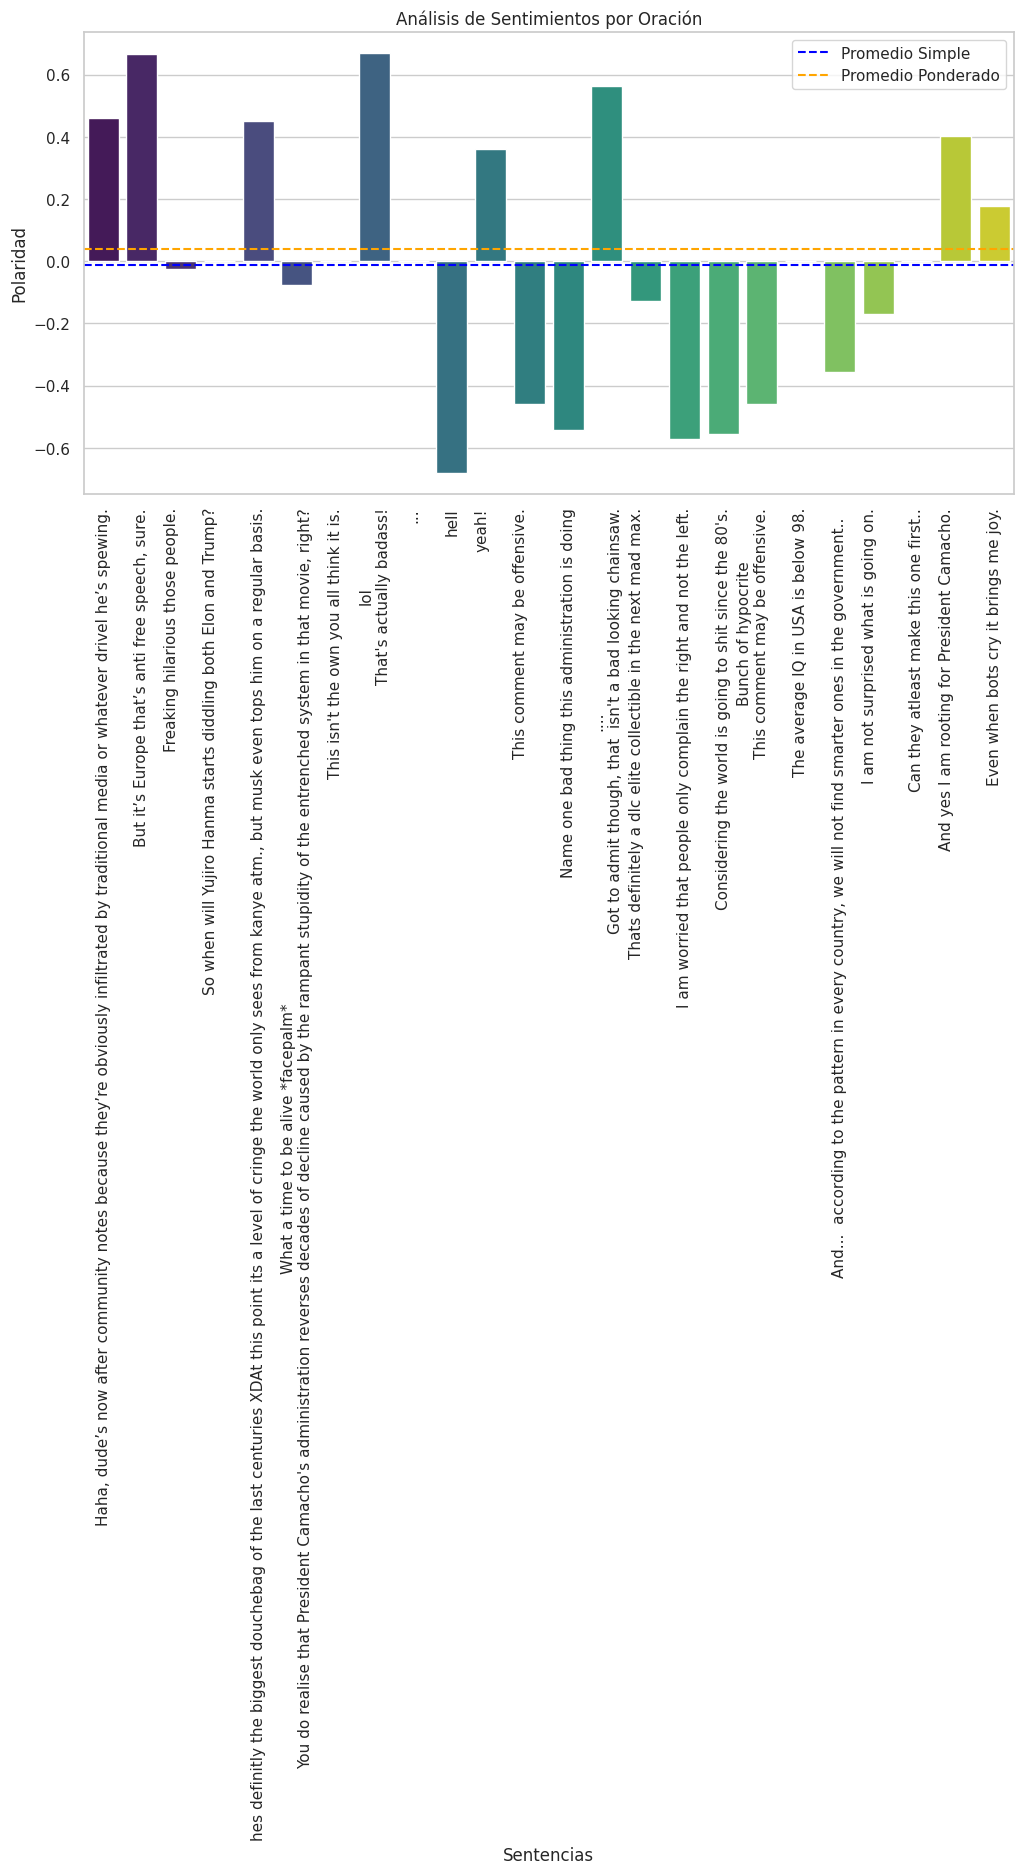

In [ ]:

# Configuración de estilo de seaborn
sns.set(style="whitegrid")

# Crear una figura y un eje
plt.figure(figsize=(12, 6))

# Gráfico de barras para la polaridad de las oraciones
sns.barplot(x='Sentencia', y='Polaridad', data=df_sentimientos, palette='viridis')

# Agregar líneas de promedio
plt.axhline(y=promedio_simple, color='blue', linestyle='--', label='Promedio Simple')
plt.axhline(y=promedio_ponderado, color='orange', linestyle='--', label='Promedio Ponderado')

# Etiquetas y título
plt.title('Análisis de Sentimientos por Oración')
plt.xlabel('Sentencias')
plt.ylabel('Polaridad')
plt.xticks(rotation=90)  # Rotar etiquetas del eje x
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()
